# Set-up of the project

In [1]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

# Packages for data preparation
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lynette/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Set some parameters that will be used throughout the notebook.

In [2]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

We read in the csv with the tweets data and perform a random shuffle. It's a good practice to shuffle the data before splitting between a train and test set. We'll only keep the video decription column as input and the Relvancy column as the target.

In [3]:
df = pd.read_csv('handlabel_feature.csv')
df.columns

Index(['Unnamed: 0', 'video_id', 'channel_title', 'channel_id',
       'video_publish_date', 'video_title', 'video_description',
       'video_category', 'video_view_count', 'video_comment_count',
       'video_like_count', 'video_dislike_count', 'video_thumbnail',
       'video_tags', 'collection_date', 'science.topic', 'Relevancy',
       'attitude', 'Text/video', 'search.term', 'cld2', 'transcript',
       'transcript_nchar', 'videoid', 'conspiracy', 'var_r', 'var_g', 'var_b',
       'var_h', 'var_s', 'var_v', 'var_bright', 'var_bright_sd',
       'var_contrast', 'var_colorful', 'median_r', 'median_g', 'median_b',
       'median_h', 'median_s', 'median_v', 'median_bright', 'median_bright_sd',
       'median_contrast', 'median_colorful', 'r_mean', 'g_mean', 'b_mean',
       'h_mean', 's_mean', 'v_mean', 'bright_mean', 'lightning_mean',
       'contrast_mean', 'colorful_mean', 'color_lag'],
      dtype='object')

In [4]:
X = df[['var_r', 'var_g', 'var_b',
       'var_h', 'var_s', 'var_v', 'var_bright', 'var_bright_sd',
       'var_contrast', 'var_colorful', 'median_r', 'median_g', 'median_b',
       'median_h', 'median_s', 'median_v', 'median_bright', 'median_bright_sd',
       'median_contrast', 'median_colorful']]

In [5]:
X

,var_r,var_g,var_b,var_h,var_s,var_v,var_bright,var_bright_sd,var_contrast,var_colorful,median_r,median_g,median_b,median_h,median_s,median_v,median_bright,median_bright_sd,median_contrast,median_colorful
0,298.035544,256.526430,317.666638,176.226486,291.471955,318.839186,249.684164,58.312728,273.094250,131.323126,99.315580,85.044938,112.727762,86.092826,134.038498,134.587656,92.603380,66.266163,220.0,74.248203
1,14.562086,13.206167,14.473241,22.249816,3.087459,14.468497,13.461712,2.128646,6.360655,0.903765,126.550148,128.666820,130.396076,83.762660,39.437676,134.533176,128.116216,75.928568,241.0,19.761427
2,1397.200532,1812.288126,1125.290200,952.795220,3386.595470,942.447595,1478.249667,160.366149,1102.429909,528.665700,82.593592,44.906568,92.771928,116.763216,175.650236,106.260372,61.527896,54.770904,190.0,71.947426
3,3404.870303,4109.476780,3996.139113,1322.958651,1390.733279,3484.537251,3852.697268,172.840076,1404.656302,165.149776,73.374364,52.725700,56.267280,59.196960,98.607484,76.760644,60.457804,51.433120,185.0,35.788363
4,800.175857,979.432379,765.202229,533.030459,899.264225,665.884765,850.382767,385.940453,2316.228370,115.950038,79.772896,73.095122,103.627240,107.586062,112.794364,110.728122,77.605316,50.424047,182.0,56.541083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,147.788425,83.104502,343.138525,287.133037,738.014925,211.022546,73.414553,233.283992,762.744039,122.025988,111.254992,113.640668,101.466524,65.478744,56.372900,122.471632,112.078180,69.131249,237.0,30.316916
403,499.048934,671.771055,464.885271,768.802809,362.948260,492.587090,554.760968,93.525503,564.382108,60.941841,123.212802,119.276686,102.296032,79.687310,70.830036,129.006988,118.347988,63.955769,210.0,34.442498
404,12.184924,9.988667,8.442325,7.628704,8.160141,12.292979,9.858782,1.924338,13.182123,6.304640,126.875756,101.686932,90.995444,37.053376,85.170332,128.535556,108.091288,70.702156,249.0,54.941191
405,3.100336,12.856796,13.246367,0.652040,23.776415,2.342890,9.398054,2.273838,0.001471,6.499906,128.762536,80.070008,88.208350,124.785384,164.544432,141.974716,95.623774,77.683406,241.0,97.623431


In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['attitude'] = le.fit_transform(df['attitude'])

In [8]:
y = df['attitude']
y.shape

(407,)

# Data preparation

## Data cleaning

The first thing we'll do is removing stopwords. These words do not have any value for predicting the sentiment.Also, we remove the http link in the texts

# Generate K-fold CV

In [10]:
from sklearn.model_selection import KFold
num_folds = 10
# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

inputs = X
targets = y

print('# inputs data samples:', inputs.shape[0])
print('# targets data samples:', targets.shape[0])

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    
#     tk = Tokenizer(num_words=NB_WORDS,
#                filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
#                lower=True,
#                split=" ")
#     tk.fit_on_texts(inputs.iloc[train])
    
#     X_train_seq = tk.texts_to_sequences(inputs.iloc[train])
#     X_test_seq = tk.texts_to_sequences(inputs.iloc[test])
    
    
    X_train_oh = inputs.iloc[train]
    X_test_oh = inputs.iloc[test]
    
    print('Shape of train set:',X_train_oh.shape)
    
    
    y_train_le = targets.iloc[train]
    y_train_oh = to_categorical(y_train_le)
    
    
    y_test_le = targets.iloc[test]
    y_test_oh = to_categorical(y_test_le)


    
    print('Shape of y:',y_train_oh.shape)

    # Define the model architecture
    base_model = models.Sequential()
    base_model.add(layers.Dense(64, activation='relu', input_shape=(20,)))
    base_model.add(layers.Dense(64, activation='relu'))
    base_model.add(layers.Dense(2, activation='softmax'))

    # Compile the model
    base_model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    print('Shape of validation set:',X_test_oh.shape)
    
    # Fit data to model
    history = base_model.fit(X_train_oh
                       ,y_train_oh
                       , epochs=50
                       , batch_size=BATCH_SIZE
                       , verbose=0)
    print(history.history)
    

    # Generate generalization metrics
    from sklearn.metrics import classification_report
    y_pred = base_model.predict_classes(X_test_oh)
    
    average_recall = recall_score(y_test_le, y_pred)
    average_precision = average_precision_score(y_test_le, y_pred)
    print(f'> Fold {fold_no} - Precison: {average_precision} - Recall: {average_recall}%')
    
    acc_per_fold.append(average_precision)
    loss_per_fold.append(average_recall)

    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')

print(f'> Precison: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Recall: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')





# inputs data samples: 407
# targets data samples: 407
Shape of train set: (366, 20)
Shape of y: (366, 2)
------------------------------------------------------------------------
Training for fold 1 ...
Shape of validation set: (41, 20)
{'loss': [106.25879669189453, 55.21419906616211, 75.1198959350586, 32.660064697265625, 22.940919876098633, 18.97317123413086, 18.643726348876953, 90.81719970703125, 65.8553695678711, 33.33571243286133, 17.25141716003418, 24.746482849121094, 25.20262908935547, 43.89271545410156, 15.709957122802734, 25.481351852416992, 44.15961837768555, 16.661338806152344, 25.02887725830078, 41.80131530761719, 15.664270401000977, 22.582473754882812, 39.13252639770508, 13.865652084350586, 22.7144775390625, 39.5237922668457, 14.496668815612793, 22.116849899291992, 38.19081497192383, 13.874444961547852, 19.97676658630371, 34.125267028808594, 10.85598373413086, 18.866031646728516, 36.630393981933594, 12.441924095153809, 19.216773986816406, 39.38705062866211, 15.4767532348632

> Fold 2 - Precison: 0.5609756097560976 - Recall: 1.0%
Shape of train set: (366, 20)
Shape of y: (366, 2)
------------------------------------------------------------------------
Training for fold 3 ...
Shape of validation set: (41, 20)
{'loss': [305.1820373535156, 82.50167846679688, 60.016597747802734, 52.170955657958984, 48.61698532104492, 47.026981353759766, 46.22585678100586, 37.0457649230957, 52.567020416259766, 21.386293411254883, 19.18686866760254, 41.25372314453125, 63.686180114746094, 26.292051315307617, 24.822185516357422, 40.92902755737305, 13.82861328125, 12.739027976989746, 17.234302520751953, 37.69935607910156, 57.892459869384766, 25.144893646240234, 16.144285202026367, 33.89816665649414, 11.131948471069336, 10.940657615661621, 19.60194206237793, 42.485443115234375, 11.74283218383789, 21.026182174682617, 48.54228973388672, 17.806760787963867, 19.339223861694336, 39.252525329589844, 11.153905868530273, 20.584186553955078, 44.61845397949219, 16.276386260986328, 17.587947845

> Fold 4 - Precison: 0.7443966995501221 - Recall: 0.9354838709677419%
Shape of train set: (366, 20)
Shape of y: (366, 2)
------------------------------------------------------------------------
Training for fold 5 ...
Shape of validation set: (41, 20)
{'loss': [134.9619140625, 33.370975494384766, 58.69575119018555, 64.05646514892578, 80.25300598144531, 37.61253356933594, 21.271268844604492, 37.26090621948242, 19.285696029663086, 38.21417999267578, 16.002241134643555, 27.62439727783203, 27.830486297607422, 56.72724151611328, 22.95014190673828, 20.95936393737793, 40.05989074707031, 12.114126205444336, 12.677444458007812, 24.637693405151367, 22.894041061401367, 52.69942855834961, 20.737552642822266, 19.120758056640625, 40.9484748840332, 12.18047046661377, 18.681774139404297, 40.278812408447266, 11.53691291809082, 18.104541778564453, 42.84105682373047, 13.446864128112793, 24.240156173706055, 47.26233673095703, 18.846908569335938, 14.447746276855469, 32.11404800415039, 8.579821586608887, 8.

> Fold 6 - Precison: 0.7476871320437342 - Recall: 0.13793103448275862%
Shape of train set: (366, 20)
Shape of y: (366, 2)
------------------------------------------------------------------------
Training for fold 7 ...
Shape of validation set: (41, 20)
{'loss': [36.902687072753906, 132.08523559570312, 41.160125732421875, 18.530298233032227, 22.816909790039062, 28.047216415405273, 38.706077575683594, 14.025179862976074, 20.682247161865234, 34.2388801574707, 11.67551040649414, 19.490459442138672, 36.1032829284668, 14.550166130065918, 17.459028244018555, 32.60617446899414, 12.627992630004883, 16.57488441467285, 30.557518005371094, 11.544832229614258, 14.963037490844727, 28.55360984802246, 10.116414070129395, 12.668684005737305, 26.696142196655273, 8.801594734191895, 11.756204605102539, 27.889068603515625, 9.193059921264648, 12.231974601745605, 28.47842025756836, 9.700113296508789, 14.724173545837402, 29.32633399963379, 10.869685173034668, 13.063621520996094, 27.127216339111328, 9.38273811

> Fold 8 - Precison: 0.75 - Recall: 1.0%
Shape of train set: (367, 20)
Shape of y: (367, 2)
------------------------------------------------------------------------
Training for fold 9 ...
Shape of validation set: (40, 20)
{'loss': [80.46319580078125, 83.47893524169922, 54.335304260253906, 36.75993728637695, 31.263643264770508, 30.26725959777832, 37.09127426147461, 51.229400634765625, 24.284902572631836, 26.784080505371094, 36.57115173339844, 19.66192054748535, 25.557693481445312, 25.470203399658203, 36.931739807128906, 15.494051933288574, 15.090009689331055, 19.269227981567383, 33.42930221557617, 13.478736877441406, 16.785858154296875, 26.623550415039062, 41.04734420776367, 15.69299602508545, 19.094579696655273, 30.410654067993164, 10.802501678466797, 10.186247825622559, 11.47294807434082, 18.24969482421875, 33.59756088256836, 10.54472541809082, 15.317480087280273, 27.066364288330078, 8.195663452148438, 7.992672920227051, 10.29607105255127, 20.17367935180664, 36.49372100830078, 14.260

> Fold 10 - Precison: 0.8356617647058824 - Recall: 0.38235294117647056%
------------------------------------------------------------------------
> Precison: 0.737202804573171 (+- 0.07317281890617236)
> Recall: 0.6732988262473638
------------------------------------------------------------------------


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

base_model = models.Sequential()
base_model.add(layers.Dense(128, activation='relu', input_shape=(10020,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(2, activation='softmax'))

X = result
y = y

my_model = KerasRegressor(build_fn=basemodel, **sk_params)    
my_model.fit(X,y)

perm = PermutationImportance(my_model, random_state=1).fit(X,y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

In [80]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name+'_24']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

In [11]:
base_model.save("visual_mlp.h5")

In [102]:
X_test_oh.shape


(31, 10020)

In [103]:
y_test_le.shape

(31,)

In [111]:
X_test_oh.shape

(31, 10020)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

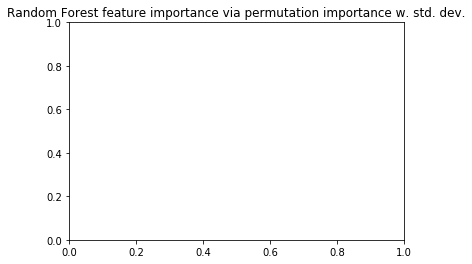

In [117]:
from mlxtend.evaluate import feature_importance_permutation
from sklearn.metrics import f1_score
imp_vals, imp_all = feature_importance_permutation(
    predict_method= base_model.predict_classes, 
    X=X_test_oh.values,
    y=y_test_le,
    metric=f1_score,
    num_rounds=10,
    seed=1)


std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
plt.title("Random Forest feature importance via permutation importance w. std. dev.")
plt.bar(range(X.shape[1]), imp_vals[indices],
        yerr=std[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [96]:
y_test_le

15     0
23     0
25     0
27     0
36     1
39     0
47     1
51     1
79     1
107    1
128    1
130    1
154    0
165    1
178    1
183    1
190    1
195    0
210    1
214    0
225    1
235    1
252    0
271    0
273    1
293    0
329    1
337    0
370    1
384    1
392    1
Name: attitude, dtype: int64

## Train-Test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.video_description, df.Relevancy, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 509
# Test data samples: 57


# Converting words to numbers

To use the text as input for a model, we first need to convert the tweet's words into tokens, which simply means converting the words to integers that refer to an index in a dictionary.

Here we will only keep the most frequent words in the train set.

We clean up the text by applying filters and putting the words to lowercase. Words are separated by spaces.

In [8]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(20))

Fitted tokenizer on 509 documents
10000 words in dictionary
Top 5 most common words are: [('coronavirus', 624), ('news', 521), ('us', 271), ('follow', 260), ('subscribe', 255), ('channel', 255), ('virus', 239), ('watch', 230), ('5g', 215), ('dr', 215), ('covid', 214), ('twitter', 214), ('video', 211), ('not', 206), ('like', 205), ('facebook', 204), ('19', 201), ('this', 184), ('people', 183), ('playlist', 181)]


After having created the dictionary we can convert the text to a list of integer indexes. This is done with the text_to_sequences method of the Tokenizer.

In [9]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))

"With theories circulating online 5G technology blame COVID-19 pandemic, experts present facts behind claims. Subscribe 7NEWS latest video ¬ª  Connect 7NEWS online Visit ¬ª  Facebook ¬ª  Twitter ¬ª  Instagram ¬ª  #BreakingNews #coronavirus #COVID19 #7NEWS" is converted into [2045, 2546, 2547, 3245, 1761, 2548, 1039, 4683, 33, 124, 582, 83, 111, 818, 1, 220, 221, 115, 3246, 32, 120, 1762, 236, 486, 765, 1, 263, 660]


These integers should now be converted into a one-hot encoded features.

In [20]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs


## Converting the target classes to numbers

In [11]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"1" is converted into 1
"1" is converted into [0. 1.]


## Splitting of a validation set


In [12]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (51, 10000)


# Model Implementation
## Baseline model

We start with a model with 2 densely connected layers of 64 hidden elements. The input_shape for the first layer is equal to the number of words we allowed in the dictionary and for which we created one-hot-encoded features.

 The softmax activation function makes sure the three probabilities sum up to 1.

In [13]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(2, activation='softmax'))
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


Because this project is a multi-class, single-label prediction, we use categorical_crossentropy as the loss function and softmax as the final activation function. We fit the model on the remaining train data and validate on the validation set. We run for a predetermined number of epochs and will see when the model starts to overfit.

In [14]:
def first_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

In [15]:
base_history = first_model(base_model)
base_history.history

{'loss': [0.7070090174674988,
  0.5174614787101746,
  0.3788684904575348,
  0.3041400909423828,
  0.25723156332969666,
  0.22602522373199463,
  0.2032897025346756,
  0.1780741959810257,
  0.1627146452665329,
  0.1489810198545456,
  0.13913194835186005,
  0.12844568490982056,
  0.11971041560173035,
  0.11082577705383301,
  0.10460763424634933,
  0.09958921372890472,
  0.09780213981866837,
  0.09410517662763596,
  0.089164137840271,
  0.08444852381944656],
 'accuracy': [0.3995633125305176,
  0.8253275156021118,
  0.8668122291564941,
  0.9017467498779297,
  0.9366812109947205,
  0.9344978332519531,
  0.9410480260848999,
  0.9454148411750793,
  0.9563318490982056,
  0.9541484713554382,
  0.9563318490982056,
  0.9563318490982056,
  0.960698664188385,
  0.960698664188385,
  0.960698664188385,
  0.960698664188385,
  0.9628821015357971,
  0.9628821015357971,
  0.9628821015357971,
  0.9628821015357971],
 'precision': [0.39427313208580017,
  0.8253275156021118,
  0.8668122291564941,
  0.90174674

To evaluate the model performance, we will look at the training and validation loss and accuracy.

## Training and Validation

lets check the model on the test set.

In [35]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results



In [94]:
test_results = test_model(base_model,30)
print(test_results)
print('Test accuracy of baseline model: {0:.2f}%'.format(test_results[1]*100))

2/2 [==============================] - 0s 1ms/step - loss: 0.8903 - accuracy: 0.8947 - precision_1: 0.8947 - recall_1: 0.8947
[0.8902625441551208, 0.8947368264198303, 0.8947368264198303, 0.8947368264198303]
Test accuracy of baseline model: 89.47%


In [95]:
y_score = base_model.predict_classes(X_test_oh)
print(y_score)

[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1
 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0]


In [96]:
from sklearn.metrics import classification_report

y_pred = base_model.predict_classes(X_test_oh)
print(y_test.ndim)
print(classification_report(y_test_le, y_pred))

1
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.93      0.93      0.93        45

    accuracy                           0.89        57
   macro avg       0.84      0.84      0.84        57
weighted avg       0.89      0.89      0.89        57



In [97]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score


average_precision = average_precision_score(y_test_le, y_pred)
print(average_precision)
average_recall = recall_score(y_test_le, y_pred)
print(average_recall)

0.9237426900584795
0.9333333333333333


In [77]:
y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

In [81]:
out_arr = np.column_stack((y_test_le, y_pred)) 

In [82]:
out_arr

array([[1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 0],
       [1, 1],
       [0, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0]])